In [1]:
# Dataset link : UTKFace : https://www.kaggle.com/datasets/jangedoo/utkface-new

##  Anatomy of ResNet50 (simplified)


| Stage    | Components                  | Output Shape         |
| -------- | --------------------------- | -------------------- |
| Input    | 224×224×3 image             |                      |
| Conv1    | 7×7 conv + MaxPool          | 112×112×64           |
| Conv2\_x | 3 residual blocks           | 56×56×256            |
| Conv3\_x | 4 residual blocks           | 28×28×512            |
| Conv4\_x | 6 residual blocks           | 14×14×1024           |
| Conv5\_x | 3 residual blocks           | 7×7×2048             |
| **Top**  | GlobalAvgPool + Dense(1000) | Final classification |


## OBJECTIVE:
 ### we are working on UTKFace dataset , and building model which can predict person's Age and Gender by seeing his/her picture

The original ResNet50:

Is trained on ImageNet for 1000-class classification

Ends with a Dense(1000, softmax) layer

But our task:

Predict age (regression): Output = 1 continuous number

Predict gender (classification): Output = 1 class (0 or 1)

So we’ll:

Remove (replace) the final dense layer

Keep base ResNet layers (feature extractor) frozen initially

Add our custom head on top

## Accessing and Downloading data from kaggle into colab

In [2]:
import os
import shutil

# Create .kaggle folder
os.makedirs('/root/.kaggle', exist_ok=True)

# Move kaggle.json to that folder
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Set permission
os.chmod('/root/.kaggle/kaggle.json', 600)


In [3]:
!kaggle datasets download -d jangedoo/utkface-new


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 92% 305M/331M [00:05<00:00, 40.7MB/s]
100% 331M/331M [00:05<00:00, 61.5MB/s]


In [4]:
import zipfile
# now we will unzip the folder

with zipfile.ZipFile("utkface-new.zip", 'r') as zip_ref:
    zip_ref.extractall("utkface")


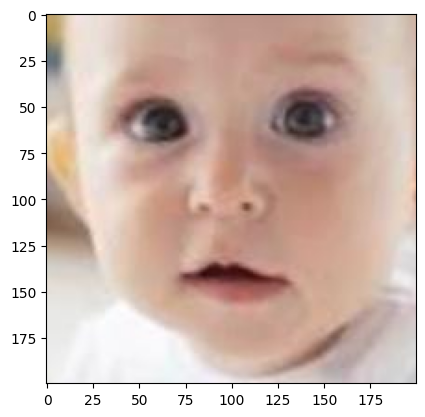

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
# List first 5 image files
images = os.listdir("/content/utkface/crop_part1")

# Open one image
img = Image.open("/content/utkface/crop_part1/" + images[1])
plt.imshow(img)
plt.show()


# STEP 1: Data Preparation

In [6]:
path = '/content/utkface/crop_part1'

## Here we will do 3 Things:
(1) Extract images from dataset
(2) Extract Age from the image's labels
(3) Extract  Gender from the image's labels

In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

In [8]:
images = []
ages = []
genders = []

for file in os.listdir(path)[:4000]:
  age = int(file.split('_')[0])
  gender = int(file.split('_')[1])

  # Load image
  img_path = os.path.join(path, file)
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))  # Required by ResNet
  img = img[..., ::-1]  # BGR to RGB
  img = preprocess_input(img)

  images.append(img)
  ages.append(age)
  genders.append(gender)



In [9]:
len(images)

4000

In [10]:
len(ages)

4000

In [11]:
len(genders)

4000

In [12]:
# Convert to NumPy arrays

# input images
X = np.array(images, dtype='float32')

# output age & gender
y_age= np.array(ages, dtype='float32')
y_gender= np.array(genders, dtype='float32')

In [13]:
X.shape , y_age.shape, y_gender.shape # samples, x-dims,y-dims , channels

((4000, 224, 224, 3), (4000,), (4000,))

In [14]:
# train test split

X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test =train_test_split(X, y_age, y_gender , test_size=0.2 , random_state=42)

# STEP 2: Load Pretrained ResNet and Modify It

In [15]:

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

In [16]:
resnet_base = ResNet50(include_top=False , weights='imagenet' , input_tensor=Input(shape=(224,224,3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [17]:
# Freeze base Layers

for layer in resnet_base.layers:
  layer.trainable=False

In [18]:
x=resnet_base.output # its shape (None, 7, 7, 2048) which is the output of last conv in Resnet architecture

In [19]:
# its shape (None, 2048)
x=GlobalAveragePooling2D()(x)  # it takes the avg values and flattens the output of last conv and input for custom Dense layers
# so, no need to fatten the layers output becasue GlobalAveragePooling2D has done this

### Adding cutome layers Dense layers (regression and classification)

In [20]:
# Dense Layer for age (regression)
age_output= Dense(1, name='age_output')(x)

In [21]:
# Dense layer for gender( classi)
gender_output= Dense(1, activation='sigmoid', name='gender_output')(x)

In [22]:
#final
model=Model(inputs= resnet_base.input, outputs= [age_output, gender_output])

## STEP 3: Compile and Train the Model

In [23]:
model.compile(optimizer='adam', loss= {'age_output':'mse' , 'gender_output':'binary_crossentropy' }, metrics={'age_output':'mse' , 'gender_output':'accuracy'})

In [24]:
model.fit(X_train, {'age_output':y_age_train,'gender_output':y_gender_train}, epochs=5 , validation_split= 0.2,shuffle=True , batch_size=32 )

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 185ms/step - age_output_loss: 969.7476 - age_output_mse: 969.7476 - gender_output_accuracy: 0.6430 - gender_output_loss: 0.6210 - loss: 970.3686 - val_age_output_loss: 587.3622 - val_age_output_mse: 587.3622 - val_gender_output_accuracy: 0.8047 - val_gender_output_loss: 0.4185 - val_loss: 587.7809
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - age_output_loss: 469.4243 - age_output_mse: 469.4243 - gender_output_accuracy: 0.8330 - gender_output_loss: 0.3969 - loss: 469.8213 - val_age_output_loss: 437.7065 - val_age_output_mse: 437.7065 - val_gender_output_accuracy: 0.8031 - val_gender_output_loss: 0.4138 - val_loss: 438.1203
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - age_output_loss: 359.1626 - age_output_mse: 359.1626 - gender_output_accuracy: 0.8390 - gender_output_loss: 0.3781 - loss: 359.5407 - val_age_output_loss: 361.9755 - val_age_output_mse: 361.9755 - val_gender_output_accuracy: 0.8047 - val_gender_output_loss: 0.4152 - val_loss: 

## STEP 4: Upload and Predict on a New Image

In [31]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

#upload your image
uploaded = files.upload()


Saving khan.jpg to khan.jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Age: 39
Predicted Gender: Male


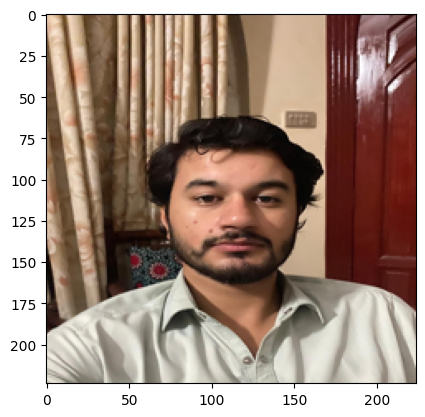

In [32]:
# preprocessing you image for prediction

for fname in uploaded.keys():
    # Load image
    img = Image.open(fname).convert('RGB')
    img = img.resize((224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    age_pred, gender_pred = model.predict(img_array)
    predicted_gender = 'Male' if np.argmax(gender_pred) == 0 else 'Female'

    print(f"Predicted Age: {int(age_pred[0][0])}")
    print(f"Predicted Gender: {predicted_gender}")

    plt.imshow(img)

In [27]:
model.save("age_gender_model.keras")

In [28]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [29]:
!cp age_gender_model.keras /content/drive/MyDrive/
